In [280]:
conda install -c conda-forge xgboost

Note: you may need to restart the kernel to use updated packages.

Solving environment: ...working... done

# All requested packages already installed.



In [281]:
conda install -c conda-forge lightgbm

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


# Устанавливаем необходимые библиотеки

In [282]:
import pandas as pd
import numpy as np

# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split 

# инструменты для оценки точности модели 
from sklearn import metrics 
from sklearn.metrics import mean_absolute_percentage_error as mape


# модуль для работы с датами.
from datetime import datetime, timedelta
import time

# модуль для работы с регулярными выражениями
import re

# модуль для работы с полиноминальными признаками
from sklearn.preprocessing import PolynomialFeatures

# Модули для визуализации
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Модули для нахождения выбросов
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
#
from IPython.display import display

# Модуль для вывода прогресса
from tqdm.notebook import tqdm

# Модули алгоритмов
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor  
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression





from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold


from sklearn.model_selection import GridSearchCV


In [283]:
# Функции

# Функции для определения выбросов
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))[0]


def outliers_z_score(ys, threshold=3):
    mean_y = np.mean(ys)
    std_y = np.std(ys)
    z_scores = [(y - mean_y) / std_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)[0]


# Функция для построения графиков распределения
def diagnostic_plots(df, variable, title):
    fig, ax = plt.subplots(figsize=(10,7))
    # гистограмма
    plt.subplot(2, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(2, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    # ящик с усами
    plt.subplot(2, 2, 3)
    sns.violinplot(x=df[variable])    
    # ящик с усами
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df[variable])  
    fig.suptitle(title)
    plt.show()
    
# Метрика   
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Чисто инженерные преобразования для приведения 
# test и train к одному виду

In [284]:
# Натройки Pandas
pd.options.display.max_rows = 50
pd.options.display.max_columns = None

In [285]:
# Подгружаем Данные train и test
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [286]:
# Сразу сбрасываем ненужные признаки
train.drop(['Unnamed: 0'], axis = 1, inplace = True)
test.drop(['car_url'], axis = 1, inplace = True)
test.drop(['model_info'], axis = 1, inplace = True)

In [287]:
# В train в столбце Price есть немного пропусков их лучше сразу удалить.
wrong_index = train[train.Price.isna()].index.tolist()
train.drop(wrong_index,axis=0, inplace = True)

In [288]:
# Добавляем к train признак 'enginePower'
train['enginePower'] = train['name'].str.extract(r'(\d{2,3})')

In [289]:
# Объеденяем train и test для обработки признаков

train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест

In [290]:
train.model_name = train.model_name.apply(lambda x: x if x != '5 серии' else '5ER')
train.model_name = train.model_name.apply(lambda x: x if x != '3 серии' else '3ER')
train.model_name = train.model_name.apply(lambda x: x if x != '7 серии' else '7ER')
train.model_name = train.model_name.apply(lambda x: x if x != '1 серии' else '1ER')
train.model_name = train.model_name.apply(lambda x: x if x != '6 серии' else '6ER')
train.model_name = train.model_name.apply(lambda x: x if x != '2 серии' else '2ER')
train.model_name = train.model_name.apply(lambda x: x if x != '4 серии' else '4ER')
train.model_name = train.model_name.apply(lambda x: x if x != '8 серии' else '8ER')
train.model_name = train.model_name.apply(lambda x: x if x != '2 серии Gran Tourer' else '2GRANDTOURER')
train.model_name = train.model_name.apply(lambda x: x if x != 'X6 M' else 'X6_M')
train.model_name = train.model_name.apply(lambda x: x if x != 'X5 M' else 'X5_M')
train.model_name = train.model_name.apply(lambda x: x if x != 'i3' else 'I3')

In [291]:
# Объеденяем
df = test.append(train, sort=False).reset_index(drop=True) # объединяем

In [292]:
# Удаляем строки где дублируются названия столбцов
df.drop(df[df['parsing_unixtime'] == 'parsing_unixtime'].index.tolist(),axis=0,inplace = True)

In [293]:
# Удаляем строки где только NaN
df.drop(df[df.bodyType.isna() == True].index.tolist(),axis=0,inplace = True)

In [294]:
# Приводим признак 'engineDisplacement' к одному виду.
df['engineDisplacement'] = df['engineDisplacement'].str.split(' ').str[0]

In [295]:
# Удаляем лишние строки в 'enginePower'
df['enginePower'] = df['enginePower'].str.split(' ').str[0]

In [296]:
# Создаем признак с абревиатурами типа трансмисии
df['typeTransmission'] = df['name'].str.extract(r'(AT|AMT|CVT|MT)')

In [297]:
# Приведем все названия брендов в столбце 'brand' к одному виду
df.brand = df.brand.str.upper()
df['brand'] = df['brand'].apply(lambda x: 'MERCEDES' if x == 'MERCEDES-BENZ' else x)

In [298]:
# Приводим признак 'parsing_unixtime' к числовому типу данных
df['parsing_unixtime'] = df['parsing_unixtime'].astype(int)

In [299]:
# Приводим признак 'parsing_unixtime' к типу данных даты
df['parsing_unixtime'] = df['parsing_unixtime'].astype('datetime64[s]')

In [300]:
# Дополним столбец 'vendor' данными.
vendor_brand = {'BMW': 'EUROPEAN', 'VOLKSWAGEN': 'EUROPEAN','NISSAN': 'JAPANESE','MERCEDES': 'EUROPEAN', 'TOYOTA': 'JAPANESE',
               'AUDI': 'EUROPEAN','MITSUBISHI': 'JAPANESE','SKODA': 'EUROPEAN','VOLVO': 'EUROPEAN','HONDA': 'JAPANESE',
               'INFINITI': 'JAPANESE','LEXUS': 'JAPANESE'}

df['vendor'] = df['brand'].map(vendor_brand)

In [301]:
# Дополним столбец 'numberOfDoors' данными.
doors_body = {'внедорожник 5 дв.': '5','седан': '4','лифтбек': '5','хэтчбек 5 дв.': '5','универсал 5 дв.': '5',
              'купе': '2','компактвэн': '5','пикап двойная кабина': '4','хэтчбек 3 дв.': '3','купе-хардтоп': '2',
              'внедорожник 3 дв.': '3','родстер': '2','кабриолет': '2','микровэн': '5','фургон': '4','седан 2 дв.': '2',
              'седан-хардтоп': '4','пикап полуторная кабина': '2','пикап одинарная кабина': '2','внедорожник открытый': '3',
              'тарга': '2','фастбек': '3','минивэн': '5', 'лимузин': '4'}

df['numberOfDoors'] = df['bodyType'].map(doors_body)

In [302]:
# Приведем признак 'vehicleConfiguration' к одному виду.
df.vehicleConfiguration = df.bodyType+' '+ df.engineDisplacement+' '+df.typeTransmission

In [303]:
# Добавим признак 'Владение_лет' а пропуски заменим медианой или средним значением.
df['Владение_лет'] = df['Владение'].str.extract(r'(\d{1,2})')
df['Владение_лет'] = df['Владение_лет'].astype(float)
df['Владение_лет'] = df['Владение_лет'].fillna(5)

In [304]:
# Добавим признак 'Владение_месяцев' а пропуски заменим медианой или средним значением.
df['Владение_месяцев'] = df['Владение'].str.extract(r'(\s\d{1,2})')
df['Владение_месяцев'] = df['Владение_месяцев'].astype(float)
df['Владение_месяцев'] = df['Владение_месяцев'].fillna(6)

In [305]:
# Убираем лишний текст из столбца 'Price' и приведем к числовому типу данных.
df.Price = df.Price.replace(r'\D','',regex=True)
df.Price = df.Price.astype(float)

In [306]:
# Приведем все строки в столбце 'fuelType' к одному регистру.
df.fuelType = df.fuelType.str.upper()

In [307]:
# Приведем все строки в столбце 'model_name' к одному регистру.
df.model_name = df.model_name.str.upper()

In [308]:
# Приведем столбец 'model_name' к одному виду
df.model_name = df.model_name.apply(lambda x: x if x != 'PASSAT CC' else 'PASSAT_CC')
df.model_name = df.model_name.apply(lambda x: x if x != 'GOLF PLUS' else 'GOLF_PLUS')

df.model_name = df.model_name.apply(lambda x: x if x != 'RAV4' else 'RAV_4')
df.model_name = df.model_name.apply(lambda x: x if x != 'LAND CRUISER PRADO' else 'LAND_CRUISER_PRADO')
df.model_name = df.model_name.apply(lambda x: x if x != 'LAND CRUISER' else 'LAND_CRUISER')
df.model_name = df.model_name.apply(lambda x: x if x != 'MARK II' else 'MARK_II')
df.model_name = df.model_name.apply(lambda x: x if x != 'CARINA E' else 'CARINA_E')
df.model_name = df.model_name.apply(lambda x: x if x != 'COROLLA SPACIO' else 'COROLLA_SPACIO')
df.model_name = df.model_name.apply(lambda x: x if x != 'SPRINTER MARINO' else 'SPRINTER_MARINO')
df.model_name = df.model_name.apply(lambda x: x if x != 'AVENSIS VERSO' else 'AVENSIS_VERSO')
df.model_name = df.model_name.apply(lambda x: x if x != 'CAMRY SOLARA' else 'CAMRY_SOLARA')
df.model_name = df.model_name.apply(lambda x: x if x != 'CARINA ED' else 'CARINA_ED')
df.model_name = df.model_name.apply(lambda x: x if x != 'COROLLA LEVIN' else 'COROLLA_LEVIN')
df.model_name = df.model_name.apply(lambda x: x if x != 'COROLLA VERSO' else 'COROLLA_VERSO')
df.model_name = df.model_name.apply(lambda x: x if x != 'FJ CRUISER' else 'FJ_CRUISER')
df.model_name = df.model_name.apply(lambda x: x if x != 'LITE ACE' else 'LITE_ACE')

df.model_name = df.model_name.apply(lambda x: x if x != 'ALMERA CLASSIC' else 'ALMERA_CLASSIC')
df.model_name = df.model_name.apply(lambda x: x if x != 'BLUEBIRD SYLPHY' else 'BLUEBIRD_SYLPHY')
df.model_name = df.model_name.apply(lambda x: x if x != 'DAYZ ROOX' else 'DAYZ_ROOX')
df.model_name = df.model_name.apply(lambda x: x if x != 'X-TRAIL' else 'X_TRAIL')
df.model_name = df.model_name.apply(lambda x: x if x != 'GT-R' else 'GT_R')
df.model_name = df.model_name.apply(lambda x: x if x != 'QASHQAI+2' else 'QASHQAI_PLUS_2')
df.model_name = df.model_name.apply(lambda x: x if x != 'NAVARA (FRONTIER)' else 'NAVARA')

df.model_name = df.model_name.apply(lambda x: x if x != 'A-КЛАСС' else 'A_KLASSE')
df.model_name = df.model_name.apply(lambda x: x if x != 'AMG GT' else 'AMG_GT')
df.model_name = df.model_name.apply(lambda x: x if x != 'B-КЛАСС' else 'B_KLASSE')
df.model_name = df.model_name.apply(lambda x: x if x != 'CLA AMG' else 'CLA_KLASSE_AMG')
df.model_name = df.model_name.apply(lambda x: x if x != 'CLA' else 'CLA_KLASSE')
df.model_name = df.model_name.apply(lambda x: x if x != 'CLK-КЛАСС' else 'CLK_KLASSE')
df.model_name = df.model_name.apply(lambda x: x if x != 'CLS' else 'CLS_KLASSE')
df.model_name = df.model_name.apply(lambda x: x if x != 'CLS AMG' else 'CLS_KLASSE_AMG')
df.model_name = df.model_name.apply(lambda x: x if x != 'C-КЛАСС' else 'C_KLASSE')
df.model_name = df.model_name.apply(lambda x: x if x != 'C-КЛАСС AMG' else 'C_KLASSE_AMG')
df.model_name = df.model_name.apply(lambda x: x if x != 'E-КЛАСС' else 'E_KLASSE')
df.model_name = df.model_name.apply(lambda x: x if x != 'E-КЛАСС AMG' else 'E_KLASSE_AMG')
df.model_name = df.model_name.apply(lambda x: x if x != 'CL-КЛАСС' else 'CL_KLASSE')
df.model_name = df.model_name.apply(lambda x: x if x != 'GLC COUPE' else 'GLC_COUPE')
df.model_name = df.model_name.apply(lambda x: x if x != 'GLC' else 'GLC_KLASSE')
df.model_name = df.model_name.apply(lambda x: x if x != 'GLB' else 'GLB_KLASSE')
df.model_name = df.model_name.apply(lambda x: x if x != 'GLA' else 'GLA_CLASS')
df.model_name = df.model_name.apply(lambda x: x if x != 'GLE' else 'GLE_KLASSE')
df.model_name = df.model_name.apply(lambda x: x if x != 'GLE AMG' else 'GLE_KLASSE_AMG')
df.model_name = df.model_name.apply(lambda x: x if x != 'GLE COUPE' else 'GLE_KLASSE_COUPE')
df.model_name = df.model_name.apply(lambda x: x if x != 'GL-КЛАСС AMG' else 'GLS_KLASSE_AMG')
df.model_name = df.model_name.apply(lambda x: x if x != 'G-КЛАСС' else 'G_KLASSE')
df.model_name = df.model_name.apply(lambda x: x if x != 'G-КЛАСС AMG' else 'G_KLASSE_AMG')
df.model_name = df.model_name.apply(lambda x: x if x != 'GL-КЛАСС' else 'GL_KLASSE')
df.model_name = df.model_name.apply(lambda x: x if x != 'GLE COUPE AMG' else 'GLE_KLASSE_COUPE_AMG')
df.model_name = df.model_name.apply(lambda x: x if x != 'GLK-КЛАСС' else 'GLK_KLASSE')
df.model_name = df.model_name.apply(lambda x: x if x != 'GLS' else 'GLS_KLASSE')
df.model_name = df.model_name.apply(lambda x: x if x != 'GLS AMG' else 'GLS_KLASSE_AMG')
df.model_name = df.model_name.apply(lambda x: x if x != 'M-КЛАСС' else 'M_KLASSE')
df.model_name = df.model_name.apply(lambda x: x if x != 'M-КЛАСС AMG' else 'M_KLASSE_AMG')
df.model_name = df.model_name.apply(lambda x: x if x != 'MAYBACH GLS' else 'MAYBACH_GLS')
df.model_name = df.model_name.apply(lambda x: x if x != 'S-КЛАСС' else 'S_KLASSE')
df.model_name = df.model_name.apply(lambda x: x if x != 'S-КЛАСС AMG' else 'S_KLASSE_AMG')
df.model_name = df.model_name.apply(lambda x: x if x != 'SL-КЛАСС' else 'SL_KLASSE')
df.model_name = df.model_name.apply(lambda x: x if x != 'SLK-КЛАСС' else 'SLK_KLASSE')
df.model_name = df.model_name.apply(lambda x: x if x != 'V-КЛАСС' else 'V_KLASSE')
df.model_name = df.model_name.apply(lambda x: x if x != 'X-КЛАСС' else 'X_KLASSE')

df.model_name = df.model_name.apply(lambda x: x if x != 'A4 ALLROAD' else 'A4_ALLROAD')
df.model_name = df.model_name.apply(lambda x: x if x != 'RS 3' else 'RS3')
df.model_name = df.model_name.apply(lambda x: x if x != 'RS 5' else 'RS5')
df.model_name = df.model_name.apply(lambda x: x if x != 'RS 6' else 'RS6')
df.model_name = df.model_name.apply(lambda x: x if x != 'RS 7' else 'RS7')
df.model_name = df.model_name.apply(lambda x: x if x != 'RS Q3' else 'RSQ3')

df.model_name = df.model_name.apply(lambda x: x if x != 'OCTAVIA RS' else 'OCTAVIA_RS')

df.model_name = df.model_name.apply(lambda x: x if x != 'ECLIPSE CROSS' else 'ECLIPSE_CROSS')
df.model_name = df.model_name.apply(lambda x: x if x != 'EK WAGON' else 'EK_WAGON')
df.model_name = df.model_name.apply(lambda x: x if x != 'LANCER EVOLUTION' else 'LANCER_EVOLUTION')
df.model_name = df.model_name.apply(lambda x: x if x != 'MONTERO SPORT' else 'MONTERO_SPORT')
df.model_name = df.model_name.apply(lambda x: x if x != 'PAJERO IO' else 'PAJERO_IO')
df.model_name = df.model_name.apply(lambda x: x if x != 'PAJERO PININ' else 'PAJERO_PININ')
df.model_name = df.model_name.apply(lambda x: x if x != 'PAJERO SPORT' else 'PAJERO_SPORT')
df.model_name = df.model_name.apply(lambda x: x if x != 'SPACE GEAR' else 'SPACE_GEAR')
df.model_name = df.model_name.apply(lambda x: x if x != 'SPACE RUNNER' else 'SPACE_RUNNER')
df.model_name = df.model_name.apply(lambda x: x if x != 'SPACE STAR' else 'SPACE_STAR')
df.model_name = df.model_name.apply(lambda x: x if x != 'SPACE WAGON' else 'SPACE_WAGON')

df.model_name = df.model_name.apply(lambda x: x if x != 'CIVIC TYPE R' else 'CIVIC_TYPE_R')
df.model_name = df.model_name.apply(lambda x: x if x != 'CR-V' else 'CR_V')
df.model_name = df.model_name.apply(lambda x: x if x != 'FR-V' else 'FR_V')
df.model_name = df.model_name.apply(lambda x: x if x != 'HR-V' else 'HR_V')


df.model_name = df.model_name.apply(lambda x: x if x != 'V40 CROSS COUNTRY' else 'V40_CC')
df.model_name = df.model_name.apply(lambda x: x if x != 'V60 CROSS COUNTRY' else 'V60_CROSS_COUNTRY')
df.model_name = df.model_name.apply(lambda x: x if x != 'V90 CROSS COUNTRY' else 'V90_CROSS_COUNTRY')


In [309]:
df.fuelType = df.fuelType.apply(lambda x: x if x != 'БЕНЗИН, ГАЗОБАЛЛОННОЕ ОБОРУДОВАНИЕ' else 'БЕНЗИН')

# Тестовая зона

# Конец тестовой зоны

# EDA

In [310]:
# Копируем датасет
data = df.copy()

# Анализ признаков

### Владение - имеет большое количество провусков нам этот признак не поможет.
### super_gen - данные в этом признаке по сути дублируют данные в других. Не поможет.
### priceCurrency - все автомобили в рублях этот признак неинформативен.
### complectation_dict - большое количество пропусков.
### equipment_dict - большое количество пропусков.
### Таможня - этот признак неинформативен.
### sell_id - этот признак неинформативен.

In [311]:
# Сразу удалим неинформативные признаки
data.drop(['Владение','super_gen','priceCurrency','modelDate','image',
           'complectation_dict','equipment_dict','Таможня','sell_id'], axis = 1, inplace = True)

In [312]:
# Пока, что удалим 'description' потом попробывать тональность.
data.drop(['description'], axis = 1, inplace = True)

In [313]:
# В столбце 'fuelType' есть пропуски все эти автомобили елетрокары заполним пропуски 'ЭЛЕКТРО'.
data.fuelType.fillna('ЭЛЕКТРО', inplace = True)

In [314]:
# В столбце 'ПТС' есть 1 пропуск заполним его модой.
data.ПТС.fillna('Оригинал', inplace = True)

In [315]:
# Изменяем типы данных на предпочтительные
data['enginePower'] = data['enginePower'].astype(int)
data.mileage = data.mileage.replace(r'\s+','',regex=True)
data['mileage'] = data['mileage'].astype(int)
data['productionDate'] = data['productionDate'].astype(int)
data.Владельцы = data.Владельцы.apply(lambda x: x[:1])
data['Владельцы'] = data['Владельцы'].astype(int)

In [316]:
# Проверим данные на дубликаты
data = data.drop_duplicates()

In [317]:
# Выделим числовые признаки
num = ['enginePower','mileage','productionDate','Владельцы','Владение_лет','Владение_месяцев','Price']
cat = data.drop(num,axis = 1).columns

In [318]:
# Посмотрим основные статистики
data[num].describe()

,enginePower,mileage,productionDate,Владельцы,Владение_лет,Владение_месяцев,Price
count,140307.000000,140307.000000,140307.000000,140307.000000,140307.000000,140307.000000,1.056210e+05
mean,194.245540,148998.992602,2010.579565,2.104271,4.998824,5.953609,1.925032e+06
std,121.764808,99553.430502,7.486593,0.866235,2.234912,1.608808,2.369287e+06
min,10.000000,1.000000,1904.000000,1.000000,1.000000,1.000000,3.500000e+04
25%,115.000000,74400.000000,2007.000000,1.000000,5.000000,6.000000,6.450000e+05
50%,160.000000,136650.000000,2012.000000,2.000000,5.000000,6.000000,1.300000e+06
75%,235.000000,203000.000000,2016.000000,3.000000,5.000000,6.000000,2.300000e+06
max,850.000000,1000000.000000,2021.000000,3.000000,42.000000,11.000000,9.000000e+07


# Наивная модель До Feuture Engineering

In [319]:
first_model = data.copy()

In [320]:
# Фиксируем RANDOM_SEED
RANDOM_SEED = 42

In [321]:
# Закодируем категориальные признаки.
for colum in cat:
    first_model[colum] = first_model[colum].astype('category').cat.codes

In [322]:
columns_test = ['bodyType','brand','productionDate','engineDisplacement','mileage',
                'fuelType','model_name']

In [323]:
# Отделяем train от test
X = first_model.query('sample == 1').drop(['sample'], axis=1)
X_sub = first_model.query('sample == 0').drop(['sample'], axis=1)

In [324]:
# Логарифмируем целевой признак так уменьшиться влияние выбросов
y = np.log(X.Price)

In [325]:
X.drop(['Price'], axis = 1, inplace = True)

In [326]:
X = X[columns_test]

In [327]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

In [328]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         plot=True
         )

model.save_model('catboost_single_model_baseline.model')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Результат 0.18% неплохо но score на Kaggle выдает в 2 раза худший результат

In [329]:
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 0.18%


In [330]:
predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(X_sub))

In [331]:
predict_submission

array([ 980436.15147413, 1230338.54999074, 1072851.50188797, ...,
        305420.22837529, 1514257.65406628, 1567438.35866012])

In [332]:
submission = pd.DataFrame({ 'sell_id': test.sell_id.values, 'price': predict_submission })
submission.to_csv("submission.csv", index=False)

# Feuture Engineering

In [333]:
# Копируем датасет
feature = data.copy()

In [334]:
# Создадим новые признаки
feature['enginePower*mileage'] = feature['enginePower']*feature['mileage']
feature['enginePower/mileage'] = feature['mileage']/feature['enginePower']
feature['productionDate*mileage'] = feature['productionDate']*feature['mileage']
feature['enginePower*productionDate'] = feature['enginePower']*feature['productionDate']
feature['enginePower*Владение_месяцев'] = feature['enginePower']*feature['Владение_месяцев']
feature['productionDate/mean/mileage'] = feature['productionDate'].map(feature.groupby('productionDate')['mileage'].mean())

In [335]:
feature['year-models'] = 2021 - feature.productionDate.apply(lambda x: int(x))
feature['mile/year'] = feature.mileage / feature['year-models']

In [336]:
# список дорогих марок, любая из которых продается сейчас выше 3 млн.
laxury = list(feature.query('Price>3e6').model_name.value_counts().keys())
# список коллекционных марок (из машин произведеных до 1960 года )
collector = list(feature.query('productionDate<1960').model_name.value_counts().keys())
# список спортивных марок(из моделей которые в среднем имеют мощность более 500 л.с.)
sport = list(feature.groupby('model_name').enginePower.mean().sort_values(ascending=False)[:40].keys())
# закодируем
for value, models in {'laxury': laxury, 'collector': collector, 'sport': sport}.items():
    mask = df['model_name'].isin(models)
    feature[value] = mask*1

# Визуализации

In [337]:
vis = feature.copy()

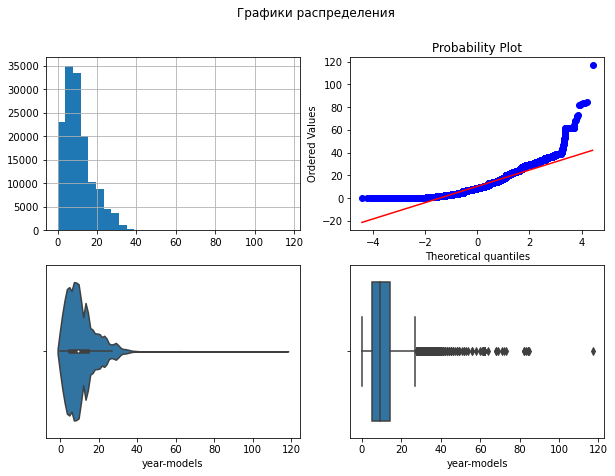

Границы межквартильных выбросов 
[ 74400. 203000.]


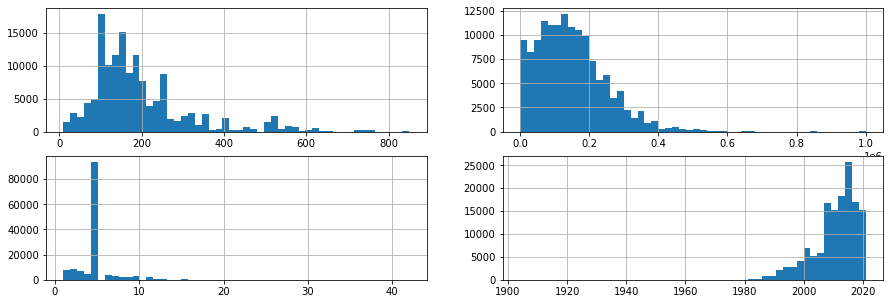

In [338]:
# Посмотрим на распределения числовых признаков
diagnostic_plots(vis, 'year-models', 'Графики распределения')
print('Границы межквартильных выбросов ')
print(np.percentile(data['mileage'], [25, 75]))

fig, ax = plt.subplots(figsize=(15,5))
plt.subplot(2, 2, 1)
vis['enginePower'].hist(bins=50)
plt.subplot(2, 2, 2)
vis['mileage'].hist(bins=50)
plt.subplot(2, 2, 3)
vis['Владение_лет'].hist(bins=50)
plt.subplot(2, 2, 4)
vis['productionDate'].hist(bins=50)
plt.show()

## Логарифмирование числовых признаков не улучшило результат.

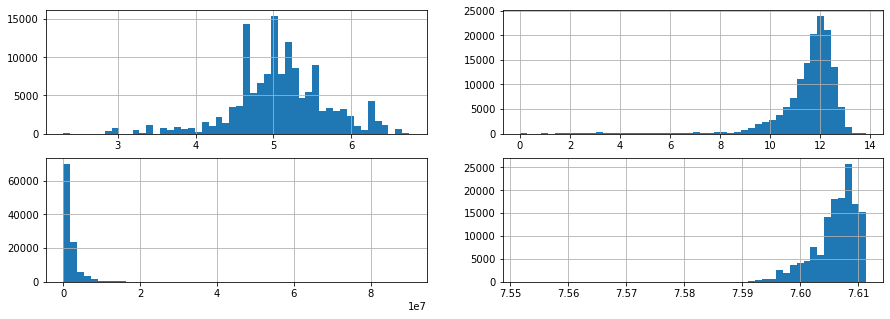

In [339]:
# Логарифмируем числовые признаки
vis['enginePower'] = np.log(vis['enginePower'])
vis['mileage'] = np.log(vis['mileage'])
vis['Владельцы'] = np.log(vis['Владельцы'])
vis['productionDate'] = np.log(vis['productionDate'])

fig, ax = plt.subplots(figsize=(15,5))
plt.subplot(2, 2, 1)
vis['enginePower'].hist(bins=50)
plt.subplot(2, 2, 2)
vis['mileage'].hist(bins=50)
plt.subplot(2, 2, 3)
vis['Price'].hist(bins=50)
plt.subplot(2, 2, 4)
vis['productionDate'].hist(bins=50)
plt.show()

In [340]:
columns_corr = ['Price','enginePower','mileage','Владельцы','mileage',
                'Владение_лет','Владение_месяцев','productionDate','year-models','mile/year']

<AxesSubplot:>

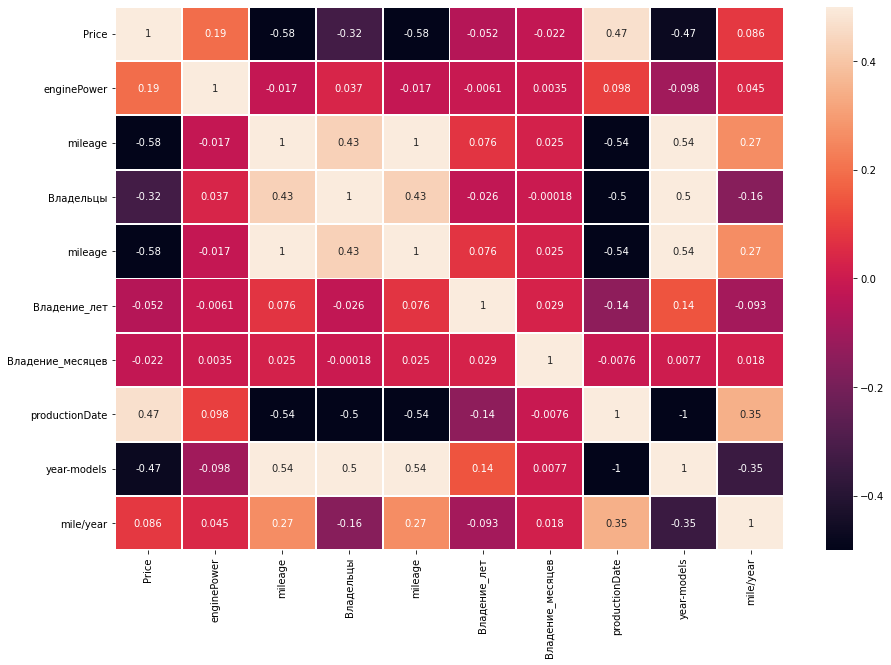

In [341]:
# Построим таблицу кореляций 
# Обнаружим сильную кореляцию признаков 'enginePower' 'mileage' 'productionDate' 'Владельцы' к целевому признаку 
# Что собственно было очевидно
# Так же признаки 'Владельцы'  и 'mileage' коррелируют между собой удалим признак 'Владельцы'
 
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(vis[columns_corr].corr(),linecolor = "white",
                                       annot = True,linewidths = 1,vmax = 0.5, vmin = -0.5)

# ML

In [342]:
# Фиксируем RANDOM_SEED
RANDOM_SEED = 42

In [343]:
test_model = feature.copy()


columns_test = ['bodyType','brand','productionDate','engineDisplacement','mileage',
                'fuelType','model_name','typeTransmission','numberOfDoors','vendor',
                'vehicleTransmission','Привод','productionDate*mileage','Владельцы','year-models',
                'mile/year', 'laxury', 'collector', 'sport'
               ]


cat = ['bodyType', 'brand', 'color', 'engineDisplacement', 'fuelType',
       'model_name', 'name', 'numberOfDoors',
       'vehicleConfiguration', 'vehicleTransmission', 'vendor', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'typeTransmission']

In [344]:
# Закодируем категориальные признаки.
for colum in cat:
    test_model[colum] = test_model[colum].astype('category').cat.codes

In [345]:
# Отделяем train от test
X = test_model.query('sample == 1').drop(['sample'], axis=1)
X_sub = test_model.query('sample == 0').drop(['sample'], axis=1)
#print(X.Price)
#X.Price = X.Price+(X.Price / 100 * 5)
#print(X.Price)

In [346]:
# Логарифмируем целевой признак так уменьшиться влияние выбросов
y = np.log(X.Price)
X.drop(['Price'], axis = 1, inplace = True)
X = X[columns_test]

In [347]:
## Закодируем категориальные признаки.
#for colum in X.columns:
#    X[colum] = X[colum].astype('category').cat.codes
#    
#for colum in X_sub.columns:
#    X_sub[colum] = X_sub[colum].astype('category').cat.codes

In [348]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

# CatBoost

In [349]:

model = CatBoostRegressor(iterations = 10000,
                          #learning_rate=0.1,
                          #depth=10,
                          l2_leaf_reg=2,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True)

model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         plot=True
         )


model.save_model('catboost_single_model_baseline.model')




MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Результат получше исходного.

In [350]:
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.10f}%")
predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(X_sub))


Точность модели по метрике MAPE: 0.0651884202%


In [351]:
submission = pd.DataFrame({ 'sell_id': test.sell_id.values, 'price': predict_submission })
submission.to_csv("submission.csv", index=False)

<AxesSubplot:>

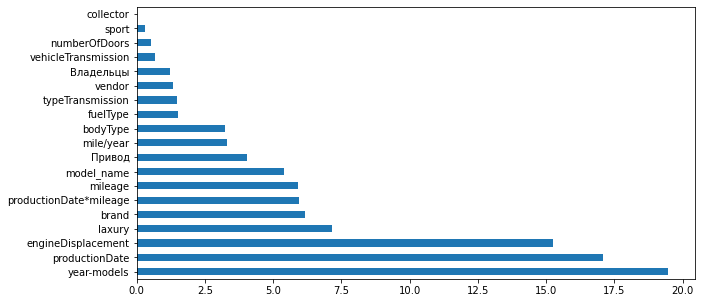

In [352]:
# Смотрим какие признаки были значимы для модели
plt.rcParams['figure.figsize'] = (10,5)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(50).plot(kind='barh')

# RandomForest

In [353]:
X_train = X_train[['bodyType','brand','productionDate','engineDisplacement','mileage',
                'fuelType','model_name','typeTransmission','numberOfDoors','vendor',
                'vehicleTransmission','Привод','productionDate*mileage','Владельцы','year-models',
                'laxury', 'collector', 'sport']]



X_test = X_test[['bodyType','brand','productionDate','engineDisplacement','mileage',
                'fuelType','model_name','typeTransmission','numberOfDoors','vendor',
                'vehicleTransmission','Привод','productionDate*mileage','Владельцы','year-models',
                'laxury', 'collector', 'sport']]

X_sub = X_sub[['bodyType','brand','productionDate','engineDisplacement','mileage',
                'fuelType','model_name','typeTransmission','numberOfDoors','vendor',
                'vehicleTransmission','Привод','productionDate*mileage','Владельцы','year-models',
                'laxury', 'collector', 'sport']]

## Показал немного лучший результат чем Cat

In [354]:
forest = RandomForestRegressor(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True, random_state=RANDOM_SEED) 

param_grid = { 
    'n_estimators': [200, 700, 1000],
    'max_depth': [2,4,8,10],
    'min_samples_leaf': [1,2,3]
}

CV_forest = GridSearchCV(estimator=forest, param_grid=param_grid, cv= 5)


CV_forest.fit(X_train, y_train)  

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_features='sqrt',
                                             n_estimators=50, n_jobs=-1,
                                             oob_score=True, random_state=42),
             param_grid={'max_depth': [2, 4, 8, 10],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [200, 700, 1000]})

In [355]:
print (CV_forest.best_params_)

{'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 700}


In [356]:
predict = CV_forest.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.10f}%")

Точность модели по метрике MAPE: 0.6449868744%


# Градиентный бустинг

#### Градиентный бустинг показал улучшение результат. Но на Kaggle ухудшение результата.

In [ ]:
Grad = GradientBoostingRegressor(min_samples_split=2,
                               learning_rate=0.1,
                               max_depth=10,
                               min_samples_leaf = 2,
                               n_estimators=5000,
                               random_state = RANDOM_SEED)


#param_grid = { 
#    'n_estimators': [1000, 2000, 5000],
#    'learning_rate': [0.1, 0.01],
#    #'learning_rate': [0.1, 0.01, 0.3],
#
#    #'max_depth': [2,4,8,10],
#    'min_samples_split': [1,2,3]
#}
#
#CV_Grad = GridSearchCV(estimator = Grad, param_grid = param_grid, cv = 5)
#
#CV_Grad.fit(X_train, y_train)  
Grad.fit(X_train, y_train)  
  
    


In [360]:
y_pred = Grad.predict(X_test)  

In [361]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.10f}%")

Точность модели по метрике MAPE: 0.0049722870%


<AxesSubplot:>

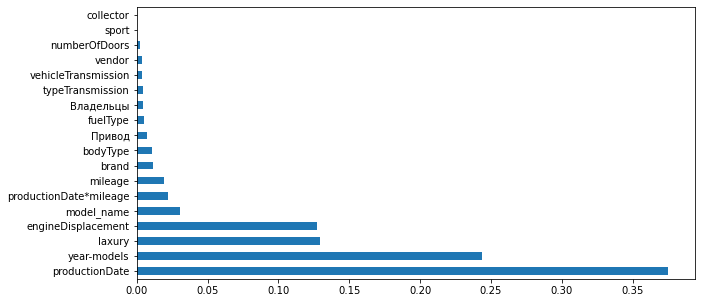

In [363]:
plt.rcParams['figure.figsize'] = (10,5)
feat_importances = pd.Series(Grad.feature_importances_, index=X_test.columns)
feat_importances.nlargest(50).plot(kind='barh')

In [364]:
predict_submission = np.exp(Grad.predict(X_sub))
submission = pd.DataFrame({ 'sell_id': test.sell_id.values, 'price': predict_submission })
submission.to_csv("submission.csv", index=False)

# Стекинг

# Стекинг показал хороший результат. Но на Kaggle очень плохой. Модель видимо переобучиваеться.

In [261]:
# По причине долгих вычислений на kaggle, пришлось ограничить число деревьев в каждом методе до 100.
estimators = [
              ('Cat', CatBoostRegressor(iterations=5000,
                                       random_seed=RANDOM_SEED,
                                       silent=True)),
    
              ('Grad', GradientBoostingRegressor(min_samples_split=2,
                               learning_rate=0.1,
                               max_depth=15,
                               n_estimators=1000,
                               random_state = RANDOM_SEED)),
    
              ('forest', RandomForestRegressor(n_jobs=-1,max_features= 'auto' ,
                                               n_estimators=1000,max_depth = 10,oob_score = True, random_state=RANDOM_SEED))
               
               ]

st_ensemble = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# оцениваем точность
st_ensemble.fit(X_train, np.log(y_train))


StackingRegressor(estimators=[('Cat',
                               <catboost.core.CatBoostRegressor object at 0x0000021859070D00>),
                              ('Grad',
                               GradientBoostingRegressor(learning_rate=0.03,
                                                         max_depth=15,
                                                         n_estimators=1000,
                                                         random_state=42)),
                              ('forest',
                               RandomForestRegressor(max_depth=10,
                                                     n_estimators=1000,
                                                     n_jobs=-1, oob_score=True,
                                                     random_state=42))],
                  final_estimator=LinearRegression())

In [264]:
predict_e = np.exp(st_ensemble.predict(X_test))

In [265]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_e))*100:0.10f}%")

Точность модели по метрике MAPE: 0.0196331638%


In [266]:
predict_submission = np.exp(st_ensemble.predict(X_sub))
submission = pd.DataFrame({ 'sell_id': test.sell_id.values, 'price': predict_submission })
submission.to_csv("submission.csv", index=False)

### Выводы

Лучший результат в Kaggle показал CatBoost видимо модель лучше обобщает чем другие.

В ноутбуке лучший результат показала модель GradientBoostingRegressor, но на Kaggle результат в 3 раза хуже чем CatBoost.
Возможно это связано с тем, что данные теста собирались год назад.  Или модель сильно переобучаеться.В связи с этим было произведено иследование изменения цен на б/у авто, где выяснилось среднее подорожание цен на 20%. Но не принесло результата. И у моделей уменьшило score на Kaggle. Для модели CatBoost был добавлен параметр регуляризации, что немного улучшило score.

Возможно стоит попробовать другие способы кодировки категориальных данных.

На что не хватило времени:

1. В связи с тем, что модели не показыват хорошего результата можно было бы вернуться к Feuture Engineering и попробовать генерацию (и добавление) новых признаков.

2. Так же видимо есть смысл эксперементировать с изменением целевой переменной, возможно (и скорее всего) 20% не истинное изменение за год.

3. Также есть смысл продолжать тестирование моделей с разными параметрами с использованием GridSearch и в ручную.

Почему не хватило времени:

1. Бoльшýю часть времени занял код парсера и парсинг данных.

Так же я имел такую часть кода:

In [ ]:
## Закодируем категориальные признаки.
#for colum in X.columns:
#    X[colum] = X[colum].astype('category').cat.codes
#    
#for colum in X_sub.columns:
#    X_sub[colum] = X_sub[colum].astype('category').cat.codes

 Что, как выяснилось кодирует данные по разному, что в свою очередь приводило к потере данных.
Все это в совокупности забрало большое количество времени и сабмитов на kaggle.